In [1]:
import pandas as pd
from transformers import BertTokenizer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r"C:\Users\Harsha\FinBert-Stock prediction\dataset\analyst_ratings_processed.csv")

In [4]:
df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [5]:
df.shape

(1400469, 4)

In [8]:
Number_of_stocks=len(df['stock'].unique())
print(Number_of_stocks)

6193


In [20]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")


df_temp = df

token_lengths = df_temp['title'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

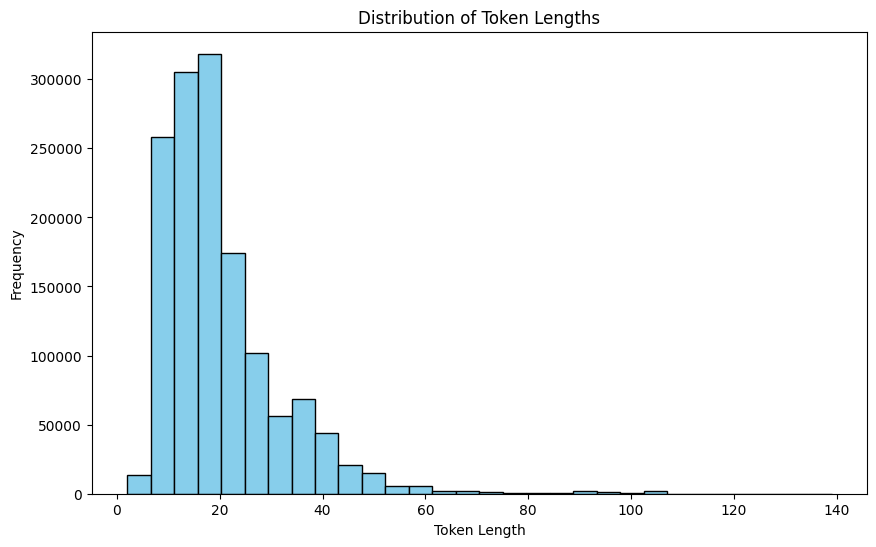

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce',utc=True)

# Filter out rows where 'date' is NaT (i.e., where date was invalid)
df = df.dropna(subset=['date'])

# Extract month and year into a new column
df['month_year'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))

# Group by 'stock' and 'month_year', and aggregate 'title' and 'date'
grouped = df.groupby(['stock', 'month_year']).apply(lambda x: x[['title', 'date']].to_dict('records')).reset_index(name='data')

# Convert the grouped data into the desired dictionary structure
grouped_data = {}
for index, row in grouped.iterrows():
    stock = row['stock']
    month_year = row['month_year']
    if stock not in grouped_data:
        grouped_data[stock] = {}
    grouped_data[stock][month_year] = row['data']

C:\Windows\Temp\ipykernel_1680\2017123262.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['stock', 'month_year']).apply(lambda x: x[['title', 'date']].to_dict('records')).reset_index(name='data')


In [5]:
len(grouped_data)

6192

In [8]:
import copy

# Deep copy the original grouped_data to ensure it's not modified
training_data = copy.deepcopy(grouped_data)

# Iterate over the copied dictionary and filter out month_year with less than 5 items
for stock in list(training_data.keys()):
    for month_year in list(training_data[stock].keys()):
        if len(training_data[stock][month_year]) < 5:
            del training_data[stock][month_year]

    # If a stock has no remaining month_year, remove the stock from the dictionary
    if not training_data[stock]:
        del training_data[stock]

In [9]:
len(training_data)

4543

In [13]:
import json
import datetime

def format_datetime(dt):
    # Format the datetime object to a string without the timezone
    dt_str = dt.strftime('%Y-%m-%d %H:%M:%S')
    # Get the timezone offset in hours and minutes
    offset_hour = int(dt.utcoffset().total_seconds() / 3600)
    offset_min = int((dt.utcoffset().total_seconds() % 3600) / 60)
    # Format the timezone offset
    offset_str = f"{offset_hour:+03d}:{offset_min:02d}"
    # Combine the datetime string with the timezone offset
    return f"{dt_str}{offset_str}"

# File path for the .jsonl file
file_path = 'training_data.jsonl'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over each stock in training_data
    for stock, month_years in training_data.items():
        # Iterate over each month_year and its corresponding data
        for month_year, entries in month_years.items():
            # Convert datetime objects to formatted strings in each entry
            for entry in entries:
                if isinstance(entry['date'], datetime.datetime):
                    entry['date'] = format_datetime(entry['date'])
            json_object = json.dumps({
                "stock": stock,
                "month_year": month_year,
                "data": entries
            })
            # Write the JSON object to the file with a newline character
            file.write(json_object + '\n')

****PolygonAPI-Demo****

In [30]:
polygon_api_key = '<Your-API-Key>'

In [15]:
import requests

def get_stock_data(ticker: str, start_date: str, end_date: str):
  # Polygon.io API URL for AAPL stock data
  url = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/month/{start_date}/{end_date}?apiKey={polygon_api_key}'

  # Make the GET request
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Parse the JSON data
      data = response.json()
      return data
  else:
      print(f'Failed to retrieve data: {response.status_code}')

In [17]:
data_AAPL=get_stock_data('AAPL','2024-01-01','2024-01-31')

In [18]:
data_AAPL

{'ticker': 'AAPL',
 'queryCount': 21,
 'resultsCount': 1,
 'adjusted': True,
 'results': [{'v': 1185397745.0,
   'vw': 187.4015,
   'o': 187.15,
   'c': 184.4,
   'h': 196.38,
   'l': 180.17,
   't': 1704085200000,
   'n': 13710414}],
 'status': 'OK',
 'request_id': 'f51bc15df70d919826be5dd7a34646e6',
 'count': 1}

In [19]:
import datetime
import calendar

def get_first_last_days(year_month_str):
    # Parse the year and month from the input string
    year, month = map(int, year_month_str.split('-'))

    # First day of the month is always 1
    first_day = datetime.date(year, month, 1)

    # Get the last day of the month
    last_day = datetime.date(year, month, calendar.monthrange(year, month)[1])

    # Calculate the first day of the next month
    if month == 12:
        next_month_first_day = datetime.date(year + 1, 1, 1)
    else:
        next_month_first_day = datetime.date(year, month + 1, 1)

    # Get the last day of the next month
    next_month_last_day = datetime.date(next_month_first_day.year, next_month_first_day.month, calendar.monthrange(next_month_first_day.year, next_month_first_day.month)[1])

    # Format the dates to the desired format
    this_month_first_day_str = first_day.strftime('%Y-%m-%d')
    this_month_last_day_str = last_day.strftime('%Y-%m-%d')
    next_month_first_day_str = next_month_first_day.strftime('%Y-%m-%d')
    next_month_last_day_str = next_month_last_day.strftime('%Y-%m-%d')

    return this_month_first_day_str, this_month_last_day_str, next_month_first_day_str, next_month_last_day_str

In [23]:
def get_all_monthly_stock_data(ticker: str):
    stock_data = []
    for month_year in training_data[ticker].keys():
        # Extract year and month from month_year
        year, month = map(int, month_year.split("-"))

        if year < 2015 or (year == 2015 and month < 12):
            continue

        this_month_first_day_str, this_month_last_day_str, next_month_first_day_str, next_month_last_day_str = get_first_last_days(month_year)
        try:
            this_month_data = get_stock_data(ticker, this_month_first_day_str, this_month_last_day_str)
            next_month_data = get_stock_data(ticker, next_month_first_day_str, next_month_last_day_str)
            monthly_stock_data = {
                "stock": ticker,
                "month_year": month_year,
                "this_month_vw": this_month_data['results'][0]['vw'],
                "next_month_vw": next_month_data['results'][0]['vw'],
            }
            monthly_stock_data['percentage_change'] = (monthly_stock_data['next_month_vw'] - monthly_stock_data['this_month_vw']) / monthly_stock_data['this_month_vw']
            stock_data.append(monthly_stock_data)
            print(f'Retrieved data for {ticker} in {month_year}')
        except:
            print(f'Failed to retrieve data for {ticker} in {month_year}')
            continue
    return stock_data

**The output is failed beacuse using polygon basic API we can only get past 2 years data. To get more past historical data we need premium access to polygon API**

In [24]:
aapl_stock_data = get_all_monthly_stock_data('AAPL')

Failed to retrieve data: 403
Failed to retrieve data: 403
Failed to retrieve data for AAPL in 2020-03
Failed to retrieve data: 403
Failed to retrieve data: 403
Failed to retrieve data for AAPL in 2020-04
Failed to retrieve data: 403
Failed to retrieve data: 429
Failed to retrieve data for AAPL in 2020-05
Failed to retrieve data: 429
Failed to retrieve data: 429
Failed to retrieve data for AAPL in 2020-06


**Combining stock price history data and training data into a cleaned dataset**

In [25]:
import json
import os

# Path to your folder containing .jsonl files
folder_path = r"C:\Users\Harsha\FinBert-Stock prediction\dataset\stock_data"

# Initialize an empty list to store the dictionaries from all files
stock_price_history_data_list = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(folder_path, filename)

        # Open and read each file
        with open(file_path, 'r') as file:
            for line in file:
                # Convert each line into a dictionary and append to the list
                stock_price_history_data_list.append(json.loads(line))

In [27]:
stock_price_history_data_list[0]

{'stock': 'A',
 'month_year': '2019-02',
 'this_month_vw': 77.448,
 'next_month_vw': 80.0518,
 'percentage_change': 0.03361997727507498}

In [28]:
stock_price_history_data = {}

for entry in stock_price_history_data_list:
    if entry['stock'] not in stock_price_history_data:
        stock_price_history_data[entry['stock']] = {}
    stock_price_history_data[entry['stock']][entry['month_year']] = {
        'this_month_vw': entry['this_month_vw'],
        'next_month_vw': entry['next_month_vw'],
        'percentage_change': entry['percentage_change'],
    }

In [29]:
# Prepare training data
import json

# Path to your .jsonl file
file_path = r"C:\Users\Harsha\FinBert-Stock prediction\dataset\training_data.jsonl"

# Initialize an empty list to store the dictionaries
training_data_list = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Convert each line into a dictionary and append to the list
        training_data_list.append(json.loads(line))

training_data = {}

for entry in training_data_list:
    if entry['stock'] not in training_data:
        training_data[entry['stock']] = {}
    training_data[entry['stock']][entry['month_year']] = entry['data']

In [32]:
for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            entry = {
                'stock': ticker,
                'month_year': month_year,
                'data': training_data[ticker][month_year]
            }
            # Store this to .jsonl file
            with open(r'C:\Users\Harsha\FinBert-Stock prediction\dataset\Final_data', 'a') as file:
                file.write(json.dumps(entry) + '\n')